In [1]:
import os
import json
from copy import copy
import pandas as pd
from sklearn.isotonic import spearmanr

PROTEINS = os.listdir("results")
PROTEINS = [file.split("-dist")[0] for file in PROTEINS if file.endswith("distances.json")]
EMBEDDINGS = ["grasr-cosine", "grasr-euclidean", "pca-cosine", "pca-euclidean", "zirke-euclidean", "zirke-cosine", "lmi-euclidean", "lmi-cosine", "lmi-30-euclidean", "lmi-30-cosine"]


def compute_correlation(file1, file2, protein_filter=None) -> float:
    """
    Compute spearman and pearson correlation between two json files.

    Args:
        file1 (str): path to first json file
        file2 (str): path to second json file
        protein_filter (list, optional): list of proteins, if not None, correlation will be computed
            only from provided list.

    Returns:
        float: spearman correlation
    """
    with open(file1) as file:
        json_x = json.load(file)
    with open(file2) as file:
        json_y = json.load(file)

    if protein_filter:
        json_x = {k: v for k, v in json_x.items() if k in protein_filter}
        json_y = {k: v for k, v in json_y.items() if k in protein_filter}

    rank_x = copy(json_x)
    rank_y = copy(json_y)
    for i, key in enumerate(json_x):
        rank_x[key] = i
        rank_y[key] = i

    spearman = spearmanr(list(rank_x.values()), list(rank_y.values()))
    return spearman.statistic


print("Proteins before filtering:", len(PROTEINS))
for protein in PROTEINS:
    with open(f"results/{protein}-distances.json") as file:
        json_file = json.load(file)
        if list(json_file.values())[1] > 0.2:
            PROTEINS.remove(protein)
print("Final sample size:", len(PROTEINS))

correlation = []
correlation_05 = []

for protein in PROTEINS:
    for embedding in EMBEDDINGS:
        correlation.append(
            (
                embedding,
                compute_correlation(f"results/{protein}-distances.json", f"results/{protein}-distances-{embedding}.json"),
            )
        )
        correlation_05.append(
            (
                embedding,
                compute_correlation(
                    f"results/{protein}-distances.json",
                    f"results/{protein}-distances-{embedding}.json",
                    [k for k, v in json.load(open(f"results/{protein}-distances.json")).items() if v > 0.5]
                ),
            )
        )

correlation = pd.DataFrame(correlation, columns=["embedding", "spearman"])
print("Spearman correlation coefficient")
print(correlation.groupby("embedding").mean().sort_values(by="spearman", ascending=False))

print("\nSpearman correlation coefficient for samples with TM-score > 0.5")
correlation_05 = pd.DataFrame(correlation_05, columns=["embedding", "spearman"])
print(correlation_05.groupby("embedding").mean().sort_values(by="spearman", ascending=False))

Proteins before filtering: 74
Final sample size: 60
Spearman correlation coefficient
                  spearman
embedding                 
zirke-cosine      0.581274
zirke-euclidean   0.575173
pca-cosine        0.537571
grasr-euclidean   0.526887
pca-euclidean     0.526887
grasr-cosine      0.526887
lmi-30-euclidean  0.267798
lmi-euclidean     0.264082
lmi-cosine        0.257110
lmi-30-cosine     0.130522

Spearman correlation coefficient for samples with TM-score > 0.5
                  spearman
embedding                 
zirke-cosine      0.294430
pca-cosine        0.247055
zirke-euclidean   0.235576
pca-euclidean     0.194974
grasr-euclidean   0.194974
grasr-cosine      0.194974
lmi-30-euclidean  0.089259
lmi-euclidean     0.062694
lmi-cosine       -0.060414
lmi-30-cosine    -0.182614


In [2]:
import numpy as np


def binary_classification(ground_truth_file, evaluate_file, offset=0, threshold=None):
    """
    Compute binary classification metrics for two json files.

    Args:
        ground_truth_file (str): path to first json file
        evaluate_file (str): path to second json file
        offset (float): skips samples in range (median-offset, median+offset)
        threshold (float): threshold for binary classification, if not set, median is used

    Returns:
        dict: dictionary with precision recall (tpr, fpr)
    """
    with open(ground_truth_file) as file:
        json_x = json.load(file)
    with open(evaluate_file) as file:
        json_y = json.load(file)

    x_threshold = np.median(list(json_x.values()))
    y_threshold = np.median(list(json_y.values()))

    if threshold:
        index = next((i for i, v in enumerate(list(json_x.values())) if v > threshold), len(json_x) - 1)
        x_threshold = list(json_x.values())[index]
        y_threshold = list(json_y.values())[index]

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for key in json_x:
        if json_x[key] < x_threshold - offset and json_y[key] < y_threshold - offset:
            true_positive += 1
        elif json_x[key] >= x_threshold + offset and json_y[key] < y_threshold - offset:
            false_positive += 1
        elif json_x[key] < x_threshold - offset and json_y[key] >= y_threshold + offset:
            false_negative += 1
        else:
            true_negative += 1

    if true_positive == 0 and (false_positive == 0 or false_negative == 0):
        return {
            "precision": 0,
            "recall": 0,
            "tpr": 0,
            "fpr": 0,
        }
    return {
            "precision": true_positive / (true_positive + false_positive),
            "recall": true_positive / (true_positive + false_negative),
            "tpr": true_positive / (true_positive + false_negative),
            "fpr": false_positive / (false_positive + true_negative),
        }

median_classification = []
offseted_classification = []

for protein in PROTEINS:
    for embedding in EMBEDDINGS:
        median_classification.append(
            (embedding,
            binary_classification(
                f"results/{protein}-distances.json", 
                f"results/{protein}-distances-{embedding}.json",
                #threshold=0.5
            ))
        )
        offseted_classification.append(
            (embedding,
            binary_classification(
                f"results/{protein}-distances.json", 
                f"results/{protein}-distances-{embedding}.json",
                offset=0.1,
                threshold=0.5,
            ))
        )

median_classification = [(emb, result["precision"], result["recall"]) for emb, result in median_classification]
median_classification = pd.DataFrame(median_classification, columns=["config", "precision", "recall"])

offseted_classification = [(emb, result["precision"], result["recall"]) for emb, result in offseted_classification]
offseted_classification = pd.DataFrame(offseted_classification, columns=["config", "precision", "recall"])


print("Median classification")
print(median_classification.groupby("config").mean().sort_values(by="precision", ascending=False))
print("\nClassification without middle values <0, 0.4> and <0.6, 1>")
print(offseted_classification.groupby("config").mean().sort_values(by="precision", ascending=False))

Median classification
                  precision    recall
config                               
zirke-euclidean    0.735161  0.735192
zirke-cosine       0.724501  0.724533
pca-cosine         0.708304  0.708337
grasr-cosine       0.706005  0.706037
grasr-euclidean    0.706005  0.706037
pca-euclidean      0.706005  0.706037
lmi-cosine         0.591558  0.591585
lmi-30-cosine      0.566876  0.566903
lmi-euclidean      0.546208  0.546239
lmi-30-euclidean   0.544423  0.544458

Classification without middle values <0, 0.4> and <0.6, 1>
                  precision    recall
config                               
lmi-30-euclidean   0.945129  0.953250
zirke-euclidean    0.930581  0.806927
zirke-cosine       0.915324  0.761948
grasr-euclidean    0.890037  0.917407
pca-euclidean      0.890037  0.917407
lmi-euclidean      0.862852  0.682368
grasr-cosine       0.850310  0.844880
pca-cosine         0.846426  0.844515
lmi-30-cosine      0.730619  0.630306
lmi-cosine         0.613090  0.632280


             config       AUC
5      zirke-cosine  0.808226
4   zirke-euclidean  0.800547
2        pca-cosine  0.765462
1   grasr-euclidean  0.755305
0      grasr-cosine  0.755305
3     pca-euclidean  0.755305
8  lmi-30-euclidean  0.690799
6     lmi-euclidean  0.675712
7        lmi-cosine  0.657648
9     lmi-30-cosine  0.598068


             config       MAP
5      zirke-cosine  0.691200
4   zirke-euclidean  0.687411
2        pca-cosine  0.664274
0      grasr-cosine  0.662973
3     pca-euclidean  0.662973
1   grasr-euclidean  0.662973
7        lmi-cosine  0.586836
6     lmi-euclidean  0.583605
8  lmi-30-euclidean  0.581936
9     lmi-30-cosine  0.559990


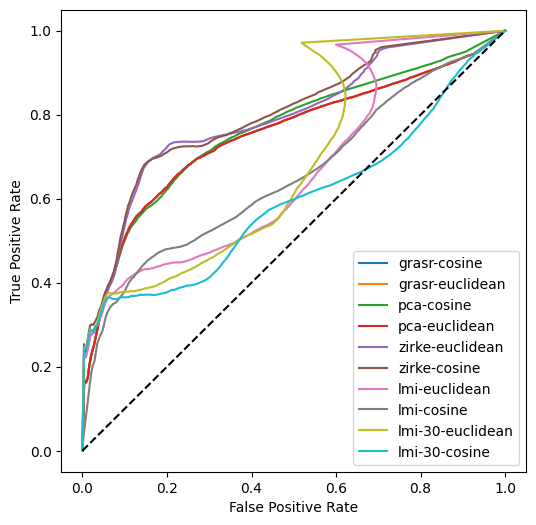

In [3]:
from matplotlib import pyplot as plt

def binary_classification(ground_truth_file, evaluate_file, index):
    """
    Compute binary classification metrics for two json files.

    Args:
        ground_truth_file (str): path to first json file
        evaluate_file (str): path to second json file
        offset (float): skips samples in range (median-offset, median+offset)
        threshold (float): threshold for binary classification, if not set, median is used

    Returns:
        dict: dictionary with precision recall (tpr, fpr)
    """
    with open(ground_truth_file) as file:
        json_x = json.load(file)
    with open(evaluate_file) as file:
        json_y = json.load(file)

    x_threshold = list(json_x.values())[index]
    y_threshold = list(json_y.values())[index]

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for key in json_x:
        if json_x[key] < x_threshold and json_y[key] < y_threshold:
            true_positive += 1
        elif json_x[key] >= x_threshold and json_y[key] < y_threshold:
            false_positive += 1
        elif json_x[key] < x_threshold and json_y[key] >= y_threshold:
            false_negative += 1
        else:
            true_negative += 1

    if true_positive == 0 and (false_positive == 0 or false_negative == 0):
        return {
            "tpr": 0,
            "fpr": 0,
        }
    return {
            "tpr": true_positive / (true_positive + false_negative),
            "fpr": false_positive / (false_positive + true_negative),
        }

precision_recall = {}
auc = {}
map = {}

for embedding in EMBEDDINGS:
    precision_recall[embedding] = []
    for i in range(0, 1900//10):
        precision_recall[embedding].append([])

for protein in PROTEINS:
    for embedding in EMBEDDINGS:
        for i in range(0, 1900, 10):
            precision_recall[embedding][i//10].append(
                binary_classification(
                    f"results/{protein}-distances.json",
                    f"results/{protein}-distances-{embedding}.json",
                    index=i,
                )
            )

for embedding in EMBEDDINGS:
    average_fpr = [[v["fpr"] for v in l] for l in precision_recall[embedding]]
    average_tpr = [[v["tpr"] for v in l] for l in precision_recall[embedding]]

    average_fpr = np.mean(average_fpr, axis=1)
    average_tpr = np.mean(average_tpr, axis=1)
    average_fpr = list(average_fpr) + [1]
    average_tpr = list(average_tpr) + [1]

    plt.plot(average_fpr, average_tpr)

    auc_score = 0
    for i in range(1, len(average_fpr)):
        auc_score += (average_fpr[i] - average_fpr[i-1]) * average_tpr[i]
    auc[embedding] = auc_score
    map[embedding] = sum(average_tpr) / len(average_tpr)

print(pd.DataFrame(auc.items(), columns=["config", "AUC"]).sort_values(by="AUC", ascending=False))
print("\n")
print(pd.DataFrame(map.items(), columns=["config", "MAP"]).sort_values(by="MAP", ascending=False))

plt.legend(EMBEDDINGS)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.gcf().set_size_inches(6, 6)
plt.show()


Distribution of distances for Cow's Alpha albumin AF-P00711-F1


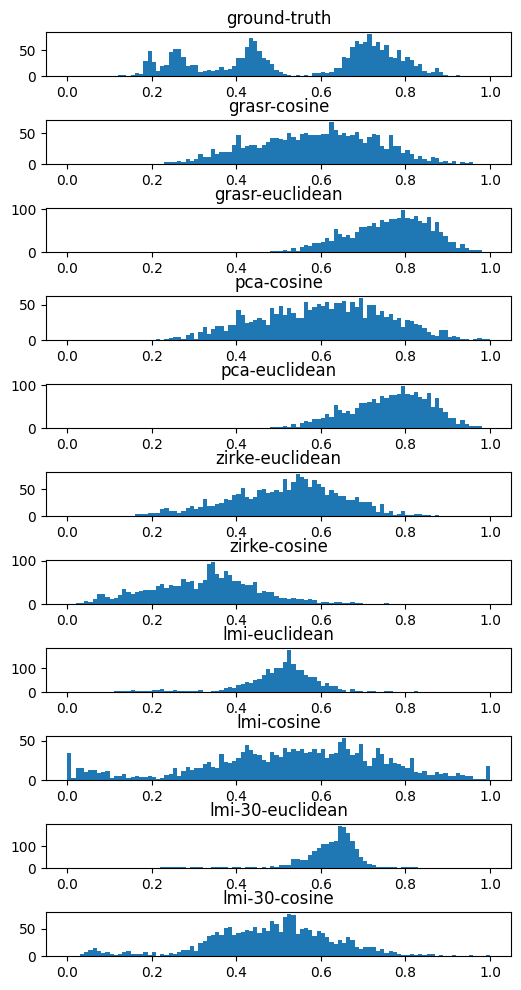

In [4]:
jsons = []
protein = "AF-P00711-F1"
with open(f"results/{protein}-distances.json", "r") as f:
    jsons.append(json.load(f))
for embedding in EMBEDDINGS:
    with open(f"results/{protein}-distances-{embedding}.json", "r") as f:
        jsons.append(json.load(f))

for index, file in enumerate(jsons):
    plt.subplot(11, 1, index+1)
    plt.subplots_adjust(hspace=1)

    plt.hist(file.values(), bins=100, range=(0,1), alpha=1)
    if index == 0:
        plt.title("ground-truth")
    else:
        plt.title(EMBEDDINGS[index-1])

plt.gcf().set_size_inches(6, 12)
print("Distribution of distances for Cow's Alpha albumin", protein)
plt.show()

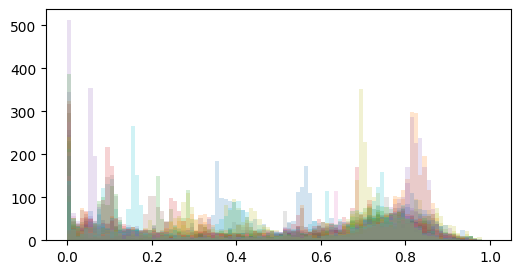

In [21]:
jsons = []

for protein in PROTEINS:
    with open(f"results/{protein}-distances.json", "r") as f:
        jsons.append(json.load(f))
for file in jsons:
    plt.hist(file.values(), bins=100, range=(0,1), alpha=0.2)

plt.gcf().set_size_inches(6, 3)
plt.show()